In [ ]:
### Regional Health Authorities

# Eastern Health: 0 
# Central Health: 1
# Western Health: 2
# Labrador-Grenfell Health: 3

# https://www.stats.gov.nl.ca/Statistics/Topics/census2016/PDF/RHA_AgeSex2016.pdf
# https://www.gov.nl.ca/hurricaneinfo/healthauthorities.htm

In [30]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import networkx as nx
from utils import get_total_2hop_connectivity, calc_R0
import shutil
import random
from matplotlib import pyplot as plt
import json

#set warningins off
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def make_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

### Overall experiment paramters


In [ ]:

#dividing_col = 'homeCommunity'
dividing_col = 'healthAuthority_ID'
hybrid_rate = "hybrid_rate_0"
subfolder_name = 'day2_0'
#subfolder_name = 'day1_0'
figure_export_path = os.path.join('DCNDP_manu_results', dividing_col)
make_dir(figure_export_path)

### Training features for decision tree rollout experiments

In [31]:
continuous_features = ['age']
categorical_features = ['schoolLevel', 'commuter', 'primcareWorker',
 'hospitalWorker', 'isPrimCarePatient', 'household_number_members', 'household_type', 'workType']


## Calculate labels for network nodes and export DCNDP_manu_results directory

In [4]:
SOL_DATA_PATH = os.path.join('DCNDP_sols')



exps_list = [{
    'path': os.path.join(SOL_DATA_PATH, 'DCNDP_NL_D2_2023_06_14_healthAuthority_ID'),
    'name': '2-hop DCNDP - agg constraints',
    'obj': get_total_2hop_connectivity,
    'label': '2-hop connectivity',
    'dividing_col': 'healthAuthority_ID',
    'dividing_col_label': 'Health authority'

},
{
    'path': os.path.join(SOL_DATA_PATH, 'DCNDP_NL_D2_2023_06_14_healthAuthority_ID_disagg'),
    'name': '2-hop DCNDP - disagg constraints',
    'obj': get_total_2hop_connectivity,
    'label': '2-hop connectivity',
    'dividing_col': 'healthAuthority_ID',
    'dividing_col_label': 'Health authority'

},
]

In [65]:
def compile_DCNDP_sol(exp_path, G_path, G_csv_path, dividing_col):
    partitions_df = pd.read_csv(os.path.join(exp_path, 'partition_results.csv'))

    data_df = pd.read_csv(G_csv_path)

    data_df['DCNDP_label'] = 0
    
    
    for index, row in partitions_df.iterrows():
        dividing_col_ident = str(row[dividing_col])
        partition = str(row['partition'])
        c_count = str(row['c_count'])


        component_sol_path = os.path.join(exp_path, dividing_col,\
            f"{dividing_col_ident}_{partition}_{c_count}", 'overall_sol.txt')

        component_sol = np.loadtxt(component_sol_path, dtype=int)

        data_df['DCNDP_label'][data_df['id'].isin(component_sol)] = 1

    #get min edge cover sol 
    min_edge_cover_sol_path = os.path.join(exp_path, 'edge_cut_sols', "cut_edge_sol.txt")
    min_edge_cover_sol = np.loadtxt(min_edge_cover_sol_path, dtype=int)
    data_df['DCNDP_label'][data_df['id'].isin(min_edge_cover_sol)] = 2

    print("calculating degrees")
    print(G_path)
    _g = nx.read_edgelist(G_path, nodetype=int)
    print("loaded graph")
    _g_degree_df = pd.DataFrame(_g.degree, columns=['id', 'degree'])
    data_df = data_df.merge(_g_degree_df, on='id', how='left')
    print('calculated degrees and inputted in df')
    return data_df

In [66]:
for exp in exps_list:
    exp_name = exp['name']
    curr_dividing_col = exp['dividing_col']
    curr_export_path = os.path.join(figure_export_path, exp_name)
    G_csv_path = os.path.join(exp['path'], 'G.csv')
    make_dir(curr_export_path)
    exp_path = os.path.join(".", exp['path'], subfolder_name,  hybrid_rate) 
    G_path = os.path.join(".", exp['path'], subfolder_name, "G.el")
    shutil.copyfile(G_path, os.path.join(curr_export_path, 'G.el'))
    data_df = compile_DCNDP_sol(exp_path, G_path, G_csv_path, curr_dividing_col)
    data_df.to_csv(os.path.join(curr_export_path, 'G.csv'), index=False)

    #copy G go curr_export_path
    # copy the file
    


calculating degrees
./DCNDP_sols/DCNDP_NL_D2_2023_06_14_healthAuthority_ID/day2_0/G.el
loaded graph
calculated degrees and inputted in df
calculating degrees
./DCNDP_sols/DCNDP_NL_D2_2023_06_14_healthAuthority_ID_disagg/day2_0/G.el
loaded graph
calculated degrees and inputted in df


## Vaccine rollout experiments

In [39]:
EXP_PATH = os.path.join('DCNDP_manu_results', 'healthAuthority_ID', '2-hop DCNDP - agg constraints')

### Function for calculating real-world baseline rollout

In [ ]:
# given a graph and it's df, caluculate the baseline rollout 
# baseline rollout was inspired by NL's 3-phase rollout plan
# see:
# https://www.gov.nl.ca/covid-19/vaccine/prioritygroups/
# https://www.gov.nl.ca/covid-19/vaccine/files/NL-COVID19-Immunization-Plan-1.pdf
def get_baseline_rollout(G_df):
    G_df = G_df.copy()
    print("calculating baseline rollout for df with shape: ", G_df.shape)

    phase_1_df = G_df[(G_df['age'] >= 85) | (G_df['primcareWorker'] > 0) | (G_df['hospitalWorker'] > 0)  | (G_df['isPrimCarePatient'] > 0)]

    phase_1_queue = list(phase_1_df['id'])
    random.shuffle(phase_1_queue)

    print("\tPhase 1 queue size: ", len(phase_1_df))
    # remove rows from original df
    G_df = G_df[~G_df['id'].isin(phase_1_queue)]
    print("\tremaining G_df size: ", len(G_df))

    phase_21_df = G_df[(G_df['age'] >= 80)]
    phase_21_queue = list(phase_21_df['id'])
    random.shuffle(phase_21_queue)
    G_df = G_df[~G_df['id'].isin(phase_21_queue)]
    print("\tPhase 21 queue size: ", len(phase_21_df))
    print("\tremaining G_df size: ", len(G_df))
    #exclude those in phase_1_df

    phase_22_df = G_df[(G_df['age'] >= 70)]
    phase_22_queue = list(phase_22_df['id'])
    random.shuffle(phase_22_queue)
    G_df = G_df[~G_df['id'].isin(phase_22_queue)]
    print("\tPhase 22 queue size: ", len(phase_22_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_23_df = G_df[(G_df['age'] >= 60)]
    phase_23_queue = list(phase_23_df['id'])
    random.shuffle(phase_23_queue)
    G_df = G_df[~G_df['id'].isin(phase_23_queue)]
    print("\tPhase 23 queue size: ", len(phase_23_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_31_df = G_df[(G_df['age'] >= 55)]
    phase_31_queue = list(phase_31_df['id'])
    random.shuffle(phase_31_queue)
    G_df = G_df[~G_df['id'].isin(phase_31_queue)]
    print("\tPhase 31 queue size: ", len(phase_31_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_32_df = G_df[(G_df['age'] >= 50)]
    phase_32_queue = list(phase_32_df['id'])
    random.shuffle(phase_32_queue)
    G_df = G_df[~G_df['id'].isin(phase_32_queue)]
    print("\tPhase 32 queue size: ", len(phase_32_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_33_df = G_df[(G_df['age'] >= 45)]
    phase_33_queue = list(phase_33_df['id'])
    random.shuffle(phase_33_queue)
    G_df = G_df[~G_df['id'].isin(phase_33_queue)]
    print("\tPhase 33 queue size: ", len(phase_33_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_34_df = G_df[(G_df['age'] >= 40)]
    phase_34_queue = list(phase_34_df['id'])
    random.shuffle(phase_34_queue)
    G_df = G_df[~G_df['id'].isin(phase_34_queue)]
    print("\tPhase 34 queue size: ", len(phase_34_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_35_df = G_df[(G_df['age'] >= 35)]
    phase_35_queue = list(phase_35_df['id'])
    random.shuffle(phase_35_queue)
    G_df = G_df[~G_df['id'].isin(phase_35_queue)]
    print("\tPhase 35 queue size: ", len(phase_35_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_36_df = G_df[(G_df['age'] >= 30)]
    phase_36_queue = list(phase_36_df['id'])
    random.shuffle(phase_36_queue)
    G_df = G_df[~G_df['id'].isin(phase_36_queue)]
    print("\tPhase 36 queue size: ", len(phase_36_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_37_df = G_df[(G_df['age'] >= 20)]
    phase_37_queue = list(phase_37_df['id'])
    random.shuffle(phase_37_queue)
    G_df = G_df[~G_df['id'].isin(phase_37_queue)]
    print("\tPhase 37 queue size: ", len(phase_37_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_38_df = G_df[(G_df['age'] >= 18)]
    phase_38_queue = list(phase_38_df['id'])
    random.shuffle(phase_38_queue)
    G_df = G_df[~G_df['id'].isin(phase_38_queue)]
    print("Phase 38 queue size: ", len(phase_38_df))
    print("remaining G_df size: ", len(G_df))

    phase_39_df = G_df[(G_df['age'] >= 12)]
    phase_39_queue = list(phase_39_df['id'])
    random.shuffle(phase_39_queue)
    G_df = G_df[~G_df['id'].isin(phase_39_queue)]
    print("\tPhase 39 queue size: ", len(phase_39_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_4_df = G_df
    phase_4_queue = list(phase_4_df['id'])
    random.shuffle(phase_4_queue)
    G_df = G_df[~G_df['id'].isin(phase_4_queue)]
    print("\tPhase 39 queue size: ", len(phase_4_df))
    print("\tremaining G_df size: ", len(G_df))

    phase_1_queue = phase_1_queue
    phase_2_queue = phase_21_queue + phase_22_queue + phase_23_queue
    phase_3_queue = phase_31_queue + phase_32_queue + phase_33_queue +\
        phase_34_queue + phase_35_queue + phase_36_queue +\
        phase_37_queue + phase_38_queue + phase_39_queue

    print("len phase_1_queue: ", len(phase_1_queue))
    print("len phase_2_queue: ", len(phase_2_queue))
    print("len phase_3_queue: ", len(phase_3_queue))
    print("len phase_4_queue: ", len(phase_4_queue))

    baseline_rollout = phase_1_queue + phase_2_queue + phase_3_queue + phase_4_queue

    return baseline_rollout

### Functions for calculating optimized rollouts both for overall graph and for indiviual regional health authorities

In [113]:


# the following two functions have been manually configured using the decision tree experiments down below. 
def get_overall_G_dcndp_rollout(G_df, prioritize_healthcare_workers=True):
    G_df = G_df.copy()
    df_encoded = pd.get_dummies(G_df, columns=categorical_features, prefix=categorical_features, prefix_sep='|').copy()

    branch_healthcare_queue = None
    if(prioritize_healthcare_workers):
        try: 
            branch_healthcare = df_encoded.loc[(df_encoded['hospitalWorker|1.0'] > 0.5) |\
            (df_encoded['primcareWorker|1.0'] > 0.5) |\
            (df_encoded['isPrimCarePatient|1.0'] > 0.5)]
        except:
            branch_healthcare = df_encoded.loc[(df_encoded['hospitalWorker|1.0'] > 0.5) |\
            (df_encoded['primcareWorker|1.0'] > 0.5)]

        branch_healthcare_queue = list(branch_healthcare['id'])
        random.shuffle(branch_healthcare_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_healthcare_queue)]
        print("Branch healthcare length: ", len(branch_healthcare_queue))

        

    # first vaccinate kids who live in crowded households
    branch_000 = df_encoded.loc[(df_encoded['schoolLevel|-1.0'] <= 0.5) &\
        (df_encoded['age'] <= 18) &\
        ((df_encoded['household_number_members|4.0'] + df_encoded['household_number_members|5.0']) > 0.5)]
    branch_000_queue = list(branch_000['id'])
    random.shuffle(branch_000_queue)
    df_encoded = df_encoded[~df_encoded['id'].isin(branch_000_queue)]
    print("Branch 000 length: ", len(branch_000_queue))

    # then vaccinate everyone else who lives in crowded households
    branch_001 = df_encoded.loc[(df_encoded['household_number_members|4.0'] +\
        df_encoded['household_number_members|5.0'] > 0.5)]
    branch_001_queue = list(branch_001['id'])
    random.shuffle(branch_001_queue)
    df_encoded = df_encoded[~df_encoded['id'].isin(branch_001_queue)]
    print("Branch 001 length: ", len(branch_001_queue))

    # then vaccinate everyother kid
    branch_010 = df_encoded.loc[df_encoded['age'] <= 18]
    branch_010_queue = list(branch_010['id'])
    random.shuffle(branch_010_queue)
    df_encoded = df_encoded[~df_encoded['id'].isin(branch_010_queue)]
    print("Branch 010 length: ", len(branch_010_queue))

    if(branch_healthcare_queue):
        proposed_priority_queue= branch_healthcare_queue + branch_000_queue + branch_001_queue + branch_010_queue
    else:
        proposed_priority_queue= branch_000_queue + branch_001_queue + branch_010_queue

    print("Proposed priority rollout length: ", len(proposed_priority_queue))

    branch_final = df_encoded
    branch_final_queue = list(branch_final['id'])
    random.shuffle(branch_final_queue)
    df_encoded = df_encoded[~df_encoded['id'].isin(branch_final_queue)]
    print("branch_final_queue: ", len(branch_final_queue))
    print("remaining data_df size: ", len(df_encoded))

    proposed_vaccine_rollout = proposed_priority_queue + branch_final_queue

    print("Rollout size: ", len(proposed_vaccine_rollout))

    return proposed_vaccine_rollout





def get_HA_dcndp_rollouts(G_df, HA_id=0, prioritize_healthcare_workers=True):
    G_df = G_df.copy()
    df_encoded = pd.get_dummies(G_df, columns=categorical_features, prefix=categorical_features, prefix_sep='|')
    branch_healthcare_queue = None
    if(prioritize_healthcare_workers):
        try: 
            branch_healthcare = df_encoded.loc[(df_encoded['hospitalWorker|1.0'] > 0.5) |\
            (df_encoded['primcareWorker|1.0'] > 0.5) |\
            (df_encoded['isPrimCarePatient|1.0'] > 0.5)]
        except:
            branch_healthcare = df_encoded.loc[(df_encoded['hospitalWorker|1.0'] > 0.5) |\
            (df_encoded['primcareWorker|1.0'] > 0.5)]

        
        branch_healthcare_queue = list(branch_healthcare['id'])
        random.shuffle(branch_healthcare_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_healthcare_queue)]
        print("Branch healthcare length: ", len(branch_healthcare_queue))

    
    if(HA_id == 0 or HA_id == 1 or HA_id == 2 or HA_id == 3):

        # first vaccinate kids who live in crowded households
        branch_000 = df_encoded.loc[(df_encoded['schoolLevel|-1.0'] <= 0.5) &\
            (df_encoded['age'] <= 18) &\
            ((df_encoded['household_number_members|4.0'] + df_encoded['household_number_members|5.0']) > 0.5)]
        branch_000_queue = list(branch_000['id'])
        random.shuffle(branch_000_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_000_queue)]
        print("Branch 000 length: ", len(branch_000_queue))

        # then vaccinate everyone else who lives in crowded households
        branch_001 = df_encoded.loc[(df_encoded['household_number_members|4.0'] +\
            df_encoded['household_number_members|5.0'] > 0.5)]
        branch_001_queue = list(branch_001['id'])
        random.shuffle(branch_001_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_001_queue)]
        print("Branch 001 length: ", len(branch_001_queue))

        # then vaccinate everyother kid
        branch_010 = df_encoded.loc[df_encoded['age'] <= 18]
        branch_010_queue = list(branch_010['id'])
        random.shuffle(branch_010_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_010_queue)]
        print("Branch 010 length: ", len(branch_010_queue))

        if(branch_healthcare_queue):
            proposed_priority_queue= branch_healthcare_queue + branch_000_queue + branch_001_queue + branch_010_queue
        else:
            proposed_priority_queue= branch_000_queue + branch_001_queue + branch_010_queue

        print("Proposed priority rollout length: ", len(proposed_priority_queue))

        branch_final = df_encoded
        branch_final_queue = list(branch_final['id'])
        random.shuffle(branch_final_queue)
        df_encoded = df_encoded[~df_encoded['id'].isin(branch_final_queue)]
        print("branch_final_queue: ", len(branch_final_queue))
        print("remaining data_df size: ", len(df_encoded))

        proposed_vaccine_rollout = proposed_priority_queue + branch_final_queue



    print("Rollout size: ", len(proposed_vaccine_rollout))

    return proposed_vaccine_rollout
        


    


### Functions for applying rollouts and calculating scores

In [60]:
def apply_rollout_R0(G, rollout, daily_budget=5*1000, fragments_day=None,
 node_remove=True, only_gcc=False, increment_degree0=None):
    G_copy = G.copy()
    R_0_scores = []
    R_0_scores.append(calc_R0(G_copy, only_gcc=only_gcc, increment_degree0=increment_degree0))
    if(fragments_day):
        fragments_score = []
        G_components = list(nx.connected_components(G_copy))
        components_len = [len(_c) for _c in G_components]
        fragments_score.append(components_len)

    day = 0
    for i in range(0, len(rollout), daily_budget): 
        curr_nodes = rollout[i:i+daily_budget]
        if(node_remove):
            G_copy.remove_nodes_from(curr_nodes)
        else: #vaccinate but not remove selected nodes
            edges_to_remove = list(G_copy.edges(curr_nodes))
            G_copy.remove_edges_from(edges_to_remove)

        if(G_copy.number_of_nodes() == 0):
            R_0_scores.append(0)
            break
        R_0_scores.append(calc_R0(G_copy, only_gcc=only_gcc, increment_degree0=increment_degree0))
        if(fragments_day):
            if(day % fragments_day == 0):
                G_components = list(nx.connected_components(G_copy))
                components_len = [len(_c) for _c in G_components]
                fragments_score.append(components_len)
        day += 1
        
    if(fragments_day):
        return R_0_scores, fragments_score
    return R_0_scores

def apply_rollout_2hop(G, rollout, daily_budget=5*1000, only_gcc=False):
    G_copy = G.copy()
    khop_scores = []
    khop_scores.append(get_total_2hop_connectivity(G))
    print("-", end="")
    day = 0
    for i in range(0, len(rollout), daily_budget): 
        curr_nodes = rollout[i:i+daily_budget]
        G_copy.remove_nodes_from(curr_nodes)

        if(G_copy.number_of_nodes() == 0):
            khop_scores.append(0)
            break
        khop_scores.append(get_total_2hop_connectivity(G_copy))
        day += 1
        print("-", end="")
        
    return khop_scores


# Recive list of rollout dicts and apply rollout on G
def apply_rollouts(rollouts_l, G, daily_budget=5*1000):
    print("!!!!!!! rollout length: ", len(rollouts_l))
    
    for rollout in rollouts_l:
        print("Rollout: ", rollout['name'])
        R_0_scores, fragments_score = apply_rollout_R0(G, rollout['rollout'],\
                                        daily_budget=daily_budget, fragments_day=10)
        rollout['R_0_scores'] = R_0_scores
        rollout['fragments_score'] = fragments_score
        khop_scores = apply_rollout_2hop(G, rollout['rollout'], daily_budget=daily_budget)
        rollout['2hop_scores'] = khop_scores

    return rollouts_l

    


### Function for plotting rollout results

In [149]:
def plot_two_by_two_line_plots(HA_exps, export_path, normalize=False):
    
    label_args = {'fontsize': 30}

    for metric in ['R_0_scores', '2hop_scores']:
        fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
        for HA_id in HA_exps:
            #find locatoin of HA_id in the 2x2 subplots. O shoud be (0,0), 1 should be (0,1), 2 should be (1,0), 3 should be (1,1)
            _x, _y = int(HA_id)//2, int(HA_id)%2
            _ax = axs[_x, _y]
            HA_name = HA_exps[HA_id]['healthAuthotity_name']
            rollouts_l = HA_exps[HA_id]['rollouts']

            #set title of a to be the HA name
            _ax.set_title(HA_name, **label_args)
            colors = ['green', 'grey']
            color_id = 0
            for rollout in rollouts_l:

                label = rollout['label']
                roll_out_scores = rollout[metric]
                if(normalize):
                    roll_out_scores = [s/roll_out_scores[0] for s in roll_out_scores]
                
                linestyle = '--'
                _ax.plot(roll_out_scores, label=label, color=colors[color_id], linestyle=linestyle, linewidth=2)
                color_id += 1
                
            #set legend on only for the upper upper right plot and on the upper right corner
            if(_x == 0 and _y == 1):
                _ax.legend(loc='upper right', fontsize=18)

            if (metric == "2hop_scores" and not normalize):
                #set log scale
                _ax.set_yscale('log')


        metric_label = "2-hop connectivity" if metric == "2hop_scores" else "R0"

        #add day as singular x label
        for ax in axs.flat:
            ax.set_xlabel('Day', **label_args)
            ax.set_ylabel(metric_label, **label_args)
            ax.label_outer()
        # If normalize true, only show axis ticks for left and bottom plots
        if(normalize):
            #for ax in axs.flat:
            #    ax.set(xlabel='Day', ylabel=metric)
            for ax in axs.flat:
                ax.label_outer()

        else:
            if metric == "2hop_scores":
                for ax in axs.flat:
                    ax.set_ylim([10e0, 10e7])
                    #set y axis ticks
                    ax.set_yticks([10e1, 10e3, 10e5, 10e7])
            else:
                for ax in axs.flat:
                    ax.set_ylim([0, 40])
                    #set y axis ticks
                    ax.set_yticks([10, 20, 30, 40])

        # change ticks font size
        for ax in axs.flat:
            ax.tick_params(axis='both', which='major',  labelsize=20)


        #fig.subplots_adjust(left=0.6, bottom=0.6)
        fig.tight_layout()

        plt.show()
        #save figure
        export_file_name = "HA_vaccine_" + metric + '_normalize_' + str(normalize) 
        fig.savefig(os.path.join(export_path, export_file_name+ '.png'), dpi=300)
        #save pdf
        fig.savefig(os.path.join(export_path, export_file_name+ '.pdf'), dpi=300)
    

            

### Read network data

In [84]:
df = pd.read_csv(os.path.join(EXP_PATH, "G.csv"))
df = df.dropna(subset=['age'])

G = nx.read_edgelist(os.path.join(EXP_PATH, "G.el"), nodetype=int)
df['DCNDP_label'].value_counts()

healthAuhority_names_map = {0: 'Eastern Health', 1: 'Central Health', 2: 'Western Health', 3: 'Labrador-Grenfell Health'}
def map_healthAuthoritys(value):
    return healthAuhority_names_map.get(value, 'Unknown')

df['healthAuthotity_name'] = df['healthAuthority_ID'].apply(map_healthAuthoritys)

df['healthAuthotity_name'].value_counts()

Eastern Health              306646
Central Health               90279
Western Health               75380
Labrador-Grenfell Health     35249
Name: healthAuthotity_name, dtype: int64

### Calculate and apply overall rollout for G

In [87]:
dcndp_rollout = get_overall_G_dcndp_rollout(df, prioritize_healthcare_workers=True)
baseline_rollout = get_baseline_rollout(df)

rollouts_l = [
    {
        'name': 'baseline',
        'rollout': baseline_rollout,
        'label': 'Real-world baseline',
        'color': 'grey',
        'linestyle': '--',
    },
    {
        'name': 'frontline_and_dcndp',
        'rollout': dcndp_rollout,
        'label': 'Frontline workers and DT',
        'color': 'green',
        'linestyle': '--',
    }

]


Branch healthcare length:  9416
Branch 000 length:  52257
Branch 001 length:  110113
Branch 010 length:  37940
Proposed priority rollout length:  209726
branch_final_queue:  297828
remaining data_df size:  0
Rollout size:  507554
calculating baseline rollout for df with shape:  (507554, 27)
	Phase 1 queue size:  20186
	remaining G_df size:  487368
	Phase 21 queue size:  11649
	remaining G_df size:  475719
	Phase 22 queue size:  45255
	remaining G_df size:  430464
	Phase 23 queue size:  77221
	remaining G_df size:  353243
	Phase 31 queue size:  40639
	remaining G_df size:  312604
	Phase 32 queue size:  39849
	remaining G_df size:  272755
	Phase 33 queue size:  35992
	remaining G_df size:  236763
	Phase 34 queue size:  32126
	remaining G_df size:  204637
	Phase 35 queue size:  29021
	remaining G_df size:  175616
	Phase 36 queue size:  27766
	remaining G_df size:  147850
	Phase 37 queue size:  52980
	remaining G_df size:  94870
Phase 38 queue size:  8716
remaining G_df size:  86154
	Phase

In [88]:
rollouts_l = apply_rollouts(rollouts_l, G, daily_budget=5000)

!!!!!!! rollout length:  2
Rollout:  baseline
-------------------------------------------------------------------------------------------------------Rollout:  frontline_and_dcndp
-------------------------------------------------------------------------------------------------------

In [89]:
# save rollouts
import pickle
with open(os.path.join(EXP_PATH, 'overall_G_rollouts.pickle'), 'wb') as handle:
    pickle.dump(rollouts_l, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load overall rollout scores and visualize

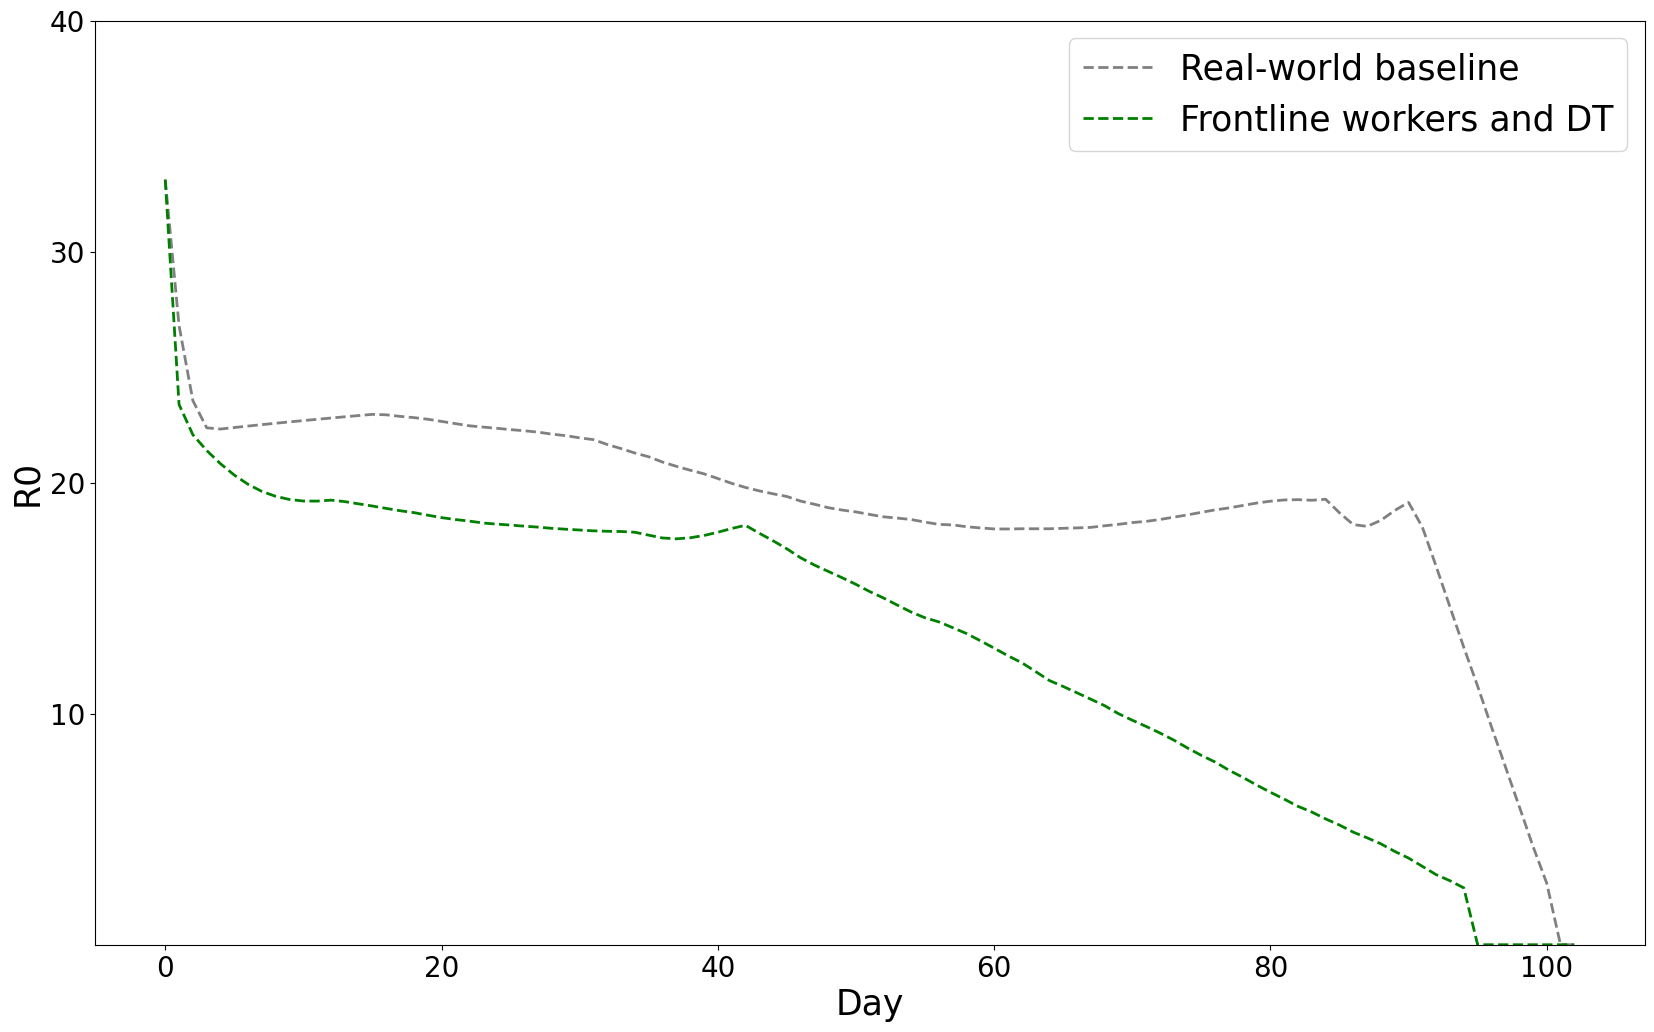

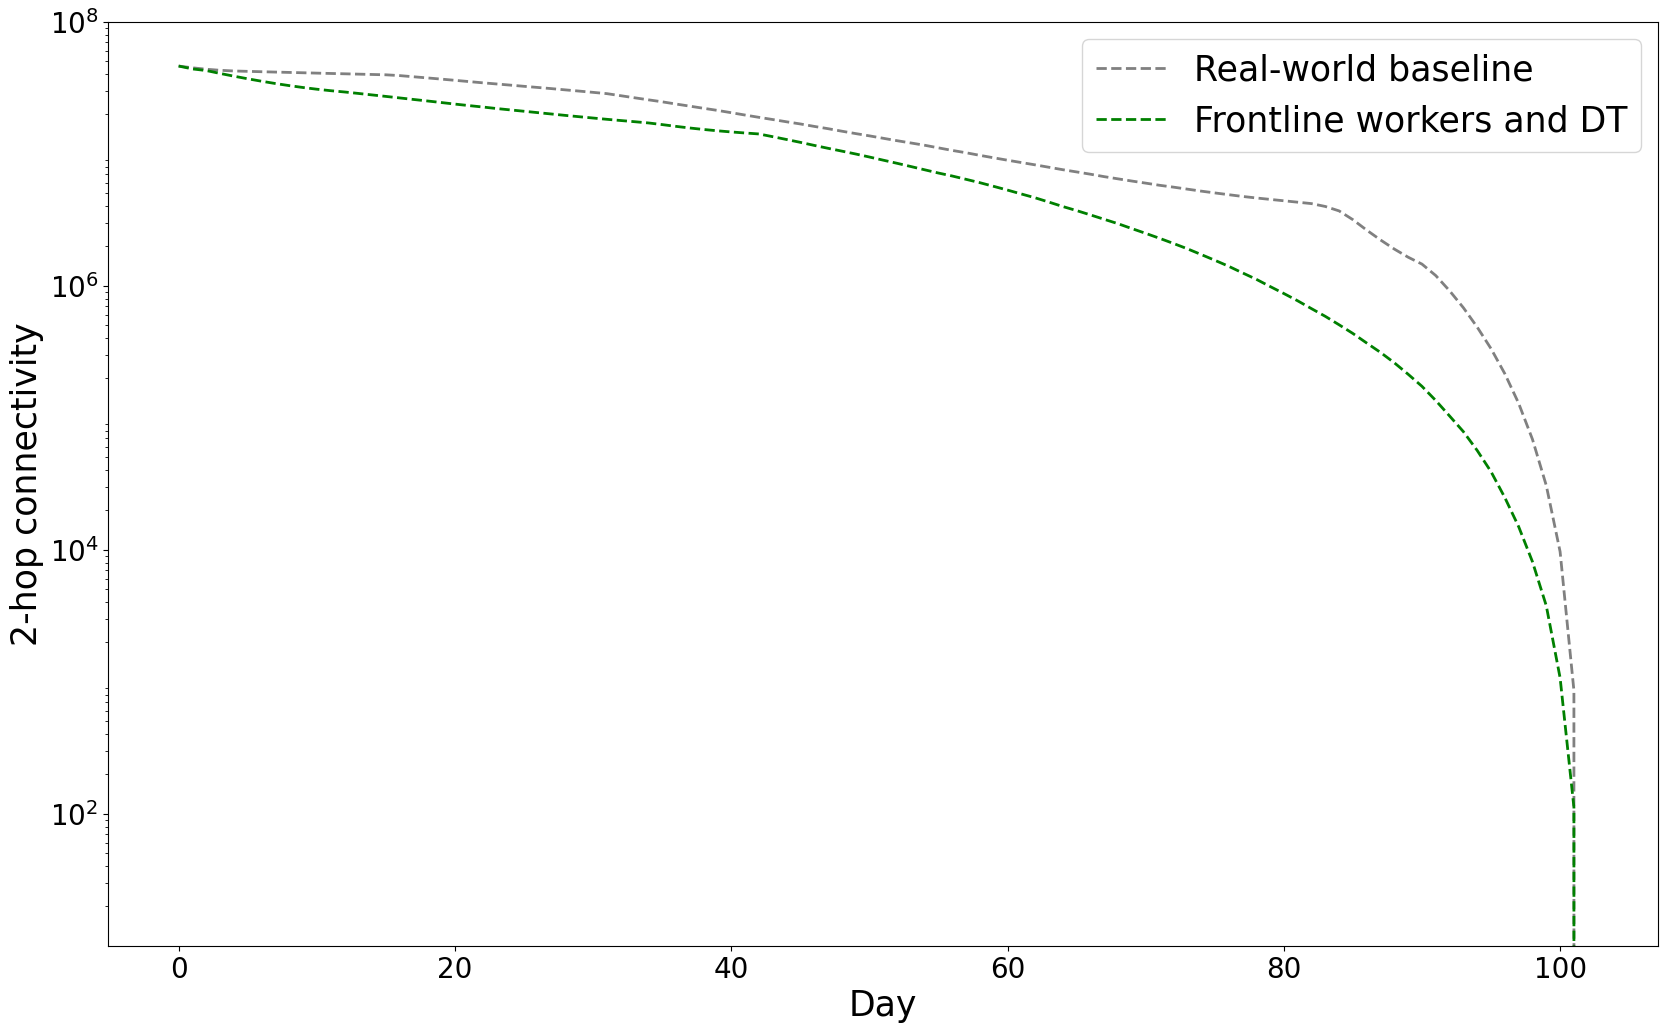

In [151]:
# loaed rollouts
with open(os.path.join(EXP_PATH, 'overall_G_rollouts.pickle'), 'rb') as handle:
    rollouts_l = pickle.load(handle)

label_args = {'fontsize': 25}
for metric in ['R_0_scores', '2hop_scores']:
    fig, ax = plt.subplots(figsize=(20, 12))

    for rollout in rollouts_l:
        label = rollout['label']
        roll_out_scores = rollout[metric]

        linestyle = rollout['linestyle']
        ax.plot(roll_out_scores, label=label, color=rollout['color'], linestyle=linestyle, linewidth=2)

    ax.legend(loc='upper right', **label_args)
    metric_label = "2-hop connectivity" if metric == "2hop_scores" else "R0"


    ax.set_xlabel('Day', **label_args)
    ax.set_ylabel(metric_label, **label_args)

    if metric == "2hop_scores":
        #set log scale
        ax.set_yscale('log')

    #enlarge ticks
    ax.tick_params(axis='both', which='major', labelsize=20)

    if(metric == "2hop_scores"):
        ax.set_ylim([10e0, 10e7])
        #set y axis ticks
        ax.set_yticks([10e1, 10e3, 10e5, 10e7])
    else:
        ax.set_ylim([0, 40])
        #set y axis ticks
        ax.set_yticks([10, 20, 30, 40])

    plt.show()
    #save figure
    export_file_name = "overallG_vaccine_" + metric
    fig.savefig(os.path.join(EXP_PATH, export_file_name+ '.png'), dpi=300)
    #save pdf
    fig.savefig(os.path.join(EXP_PATH, export_file_name+ '.pdf'), dpi=300)
    

### Rollouts for individual regional health authorities

In [ ]:

HA_exps = {}
for HA_id in healthAuhority_names_map.keys():
    print("++++Current HA: ", HA_id, " - ", healthAuhority_names_map[HA_id])
    hA_name = healthAuhority_names_map[HA_id]
    sub_df = df[df['healthAuthotity_name'] == hA_name].copy()
    #use the id column to get subgraph
    sub_G = G.subgraph(sub_df['id'].values).copy()

    HA_exps[HA_id] = {}
    HA_exps[HA_id]['healthAuthotity_name'] = hA_name
    #HA_exps[HA_id]['G'] = sub_G
    HA_exps[HA_id]['daily_budget'] = sub_G.number_of_nodes() // 100
    #HA_exps[HA_id]['df'] = sub_df
    HA_exps[HA_id]['rollouts'] = []

    dcndp_rollout = get_HA_dcndp_rollouts(sub_df, HA_id=HA_id, prioritize_healthcare_workers=True)
    baseline_rollout = get_baseline_rollout(sub_df)

    HA_exps[HA_id]['rollouts'].append({'name': 'frontline_and_dcndp', 'rollout': dcndp_rollout, 'label': 'Frontline workers and DT'})
    HA_exps[HA_id]['rollouts'].append({'name': 'baseline', 'rollout': baseline_rollout, 'label': 'Real-world baseline'})


    HA_exps[HA_id]['rollouts'] = apply_rollouts(HA_exps[HA_id]['rollouts'], sub_G, daily_budget=HA_exps[HA_id]['daily_budget'])






In [64]:
# save HA_exps as json
HA_exps_export_path = os.path.join(EXP_PATH, 'HA_exps.json')
with open(HA_exps_export_path, 'w') as fp:
    json.dump(HA_exps, fp)

### Load individual rollout scores and visualize

/var/folders/gs/p21_l1950qj722k64j15hmgc0000gn/T/ipykernel_12057/1526085568.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


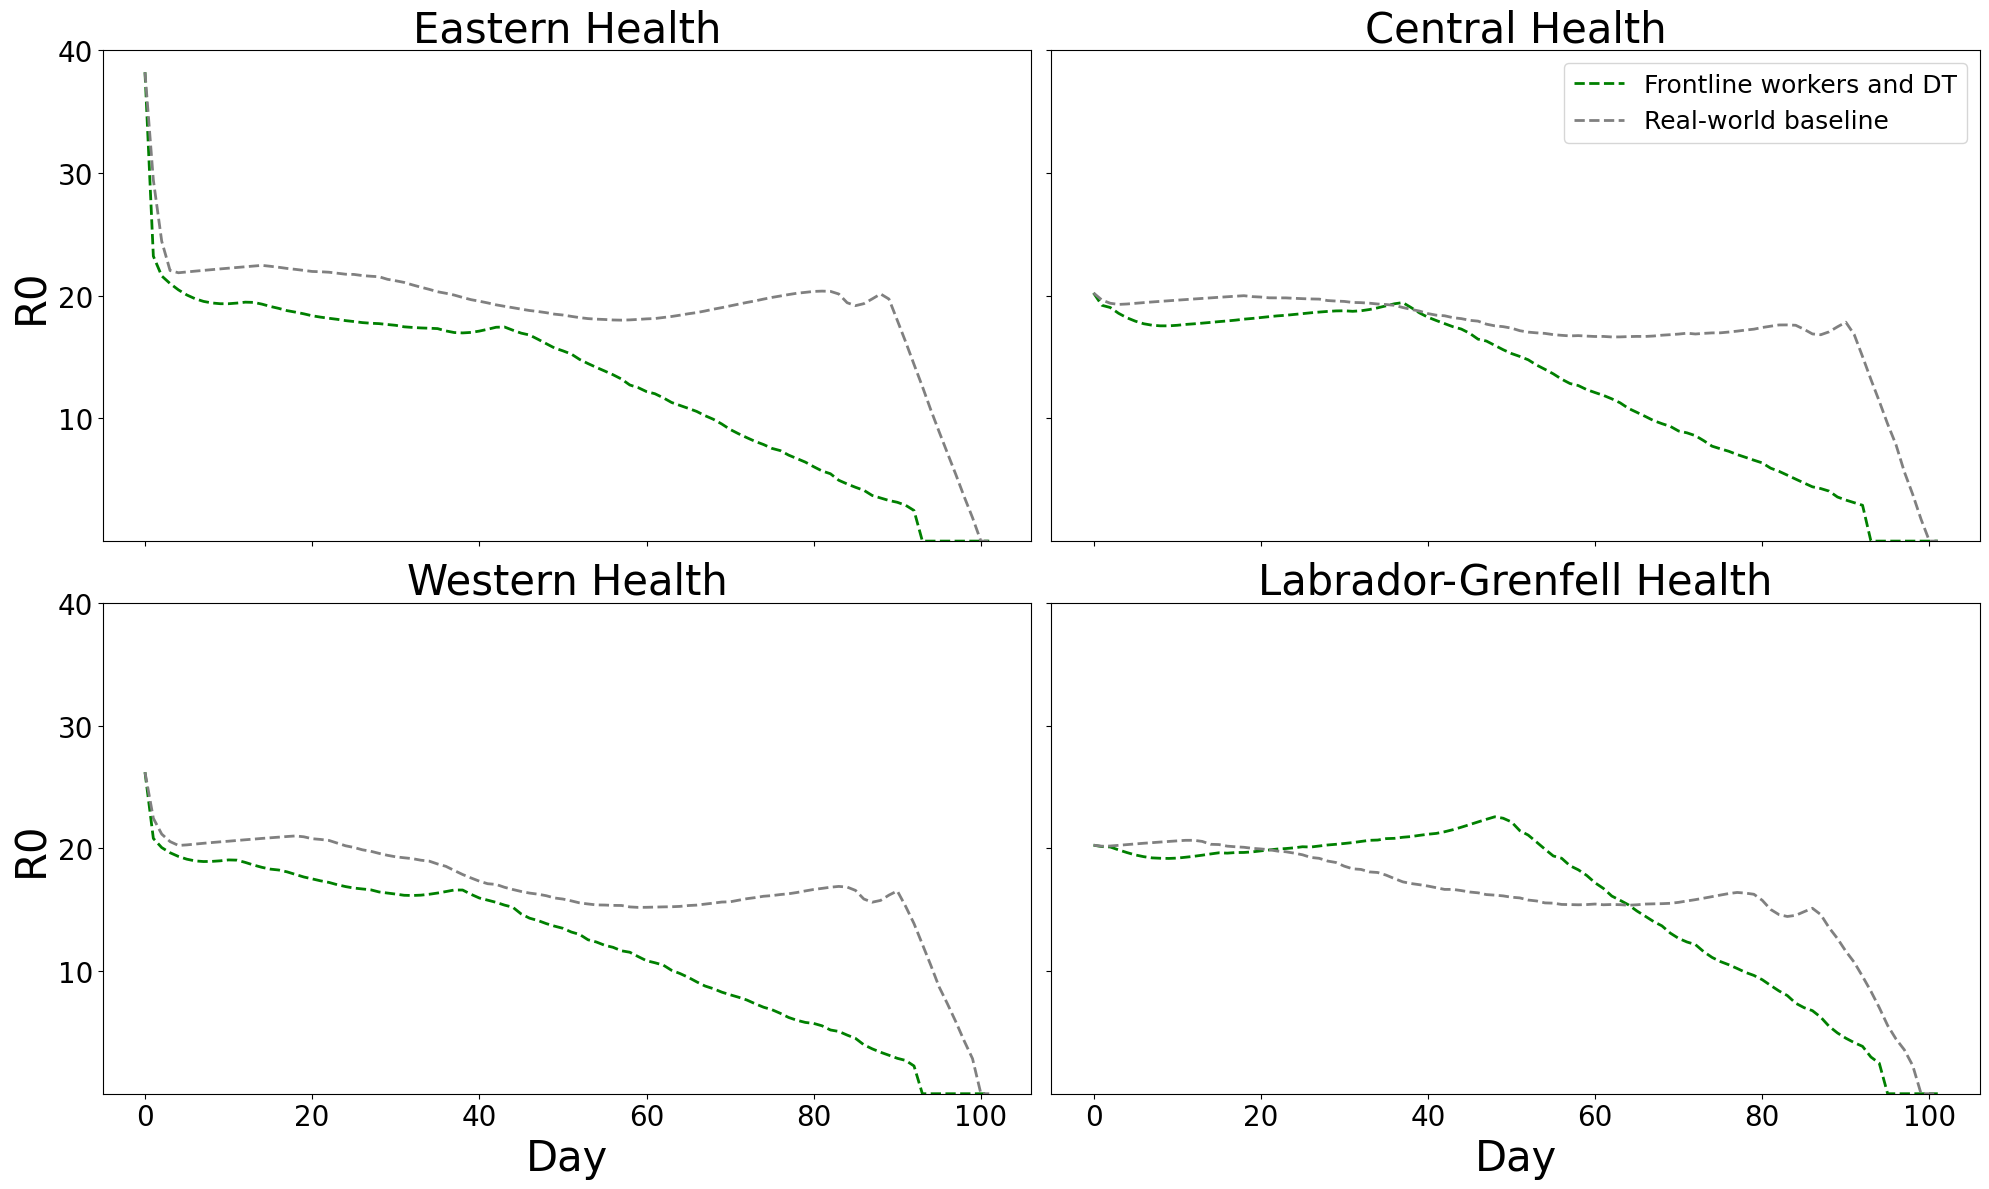

/var/folders/gs/p21_l1950qj722k64j15hmgc0000gn/T/ipykernel_12057/1526085568.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


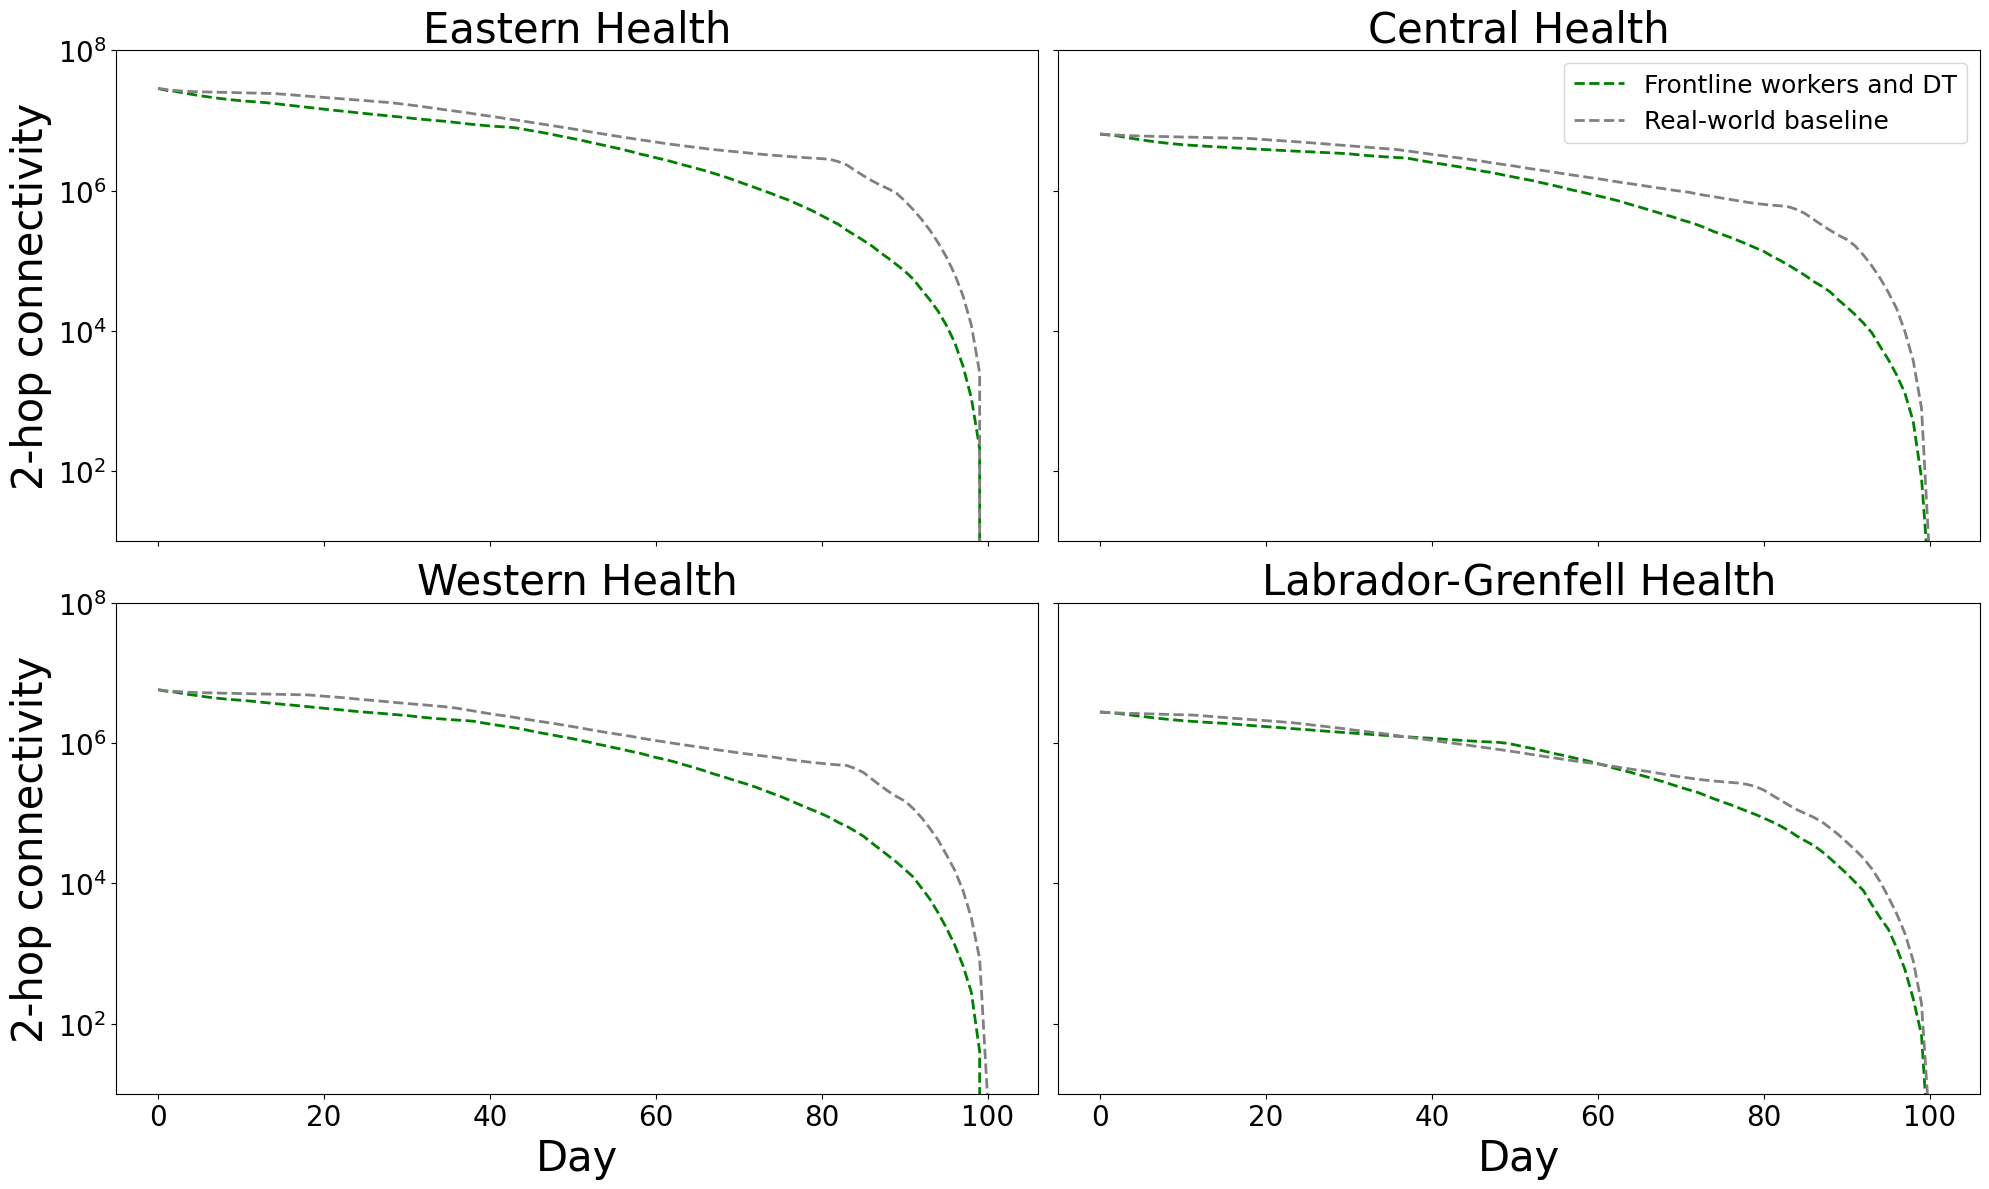

/var/folders/gs/p21_l1950qj722k64j15hmgc0000gn/T/ipykernel_12057/1526085568.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


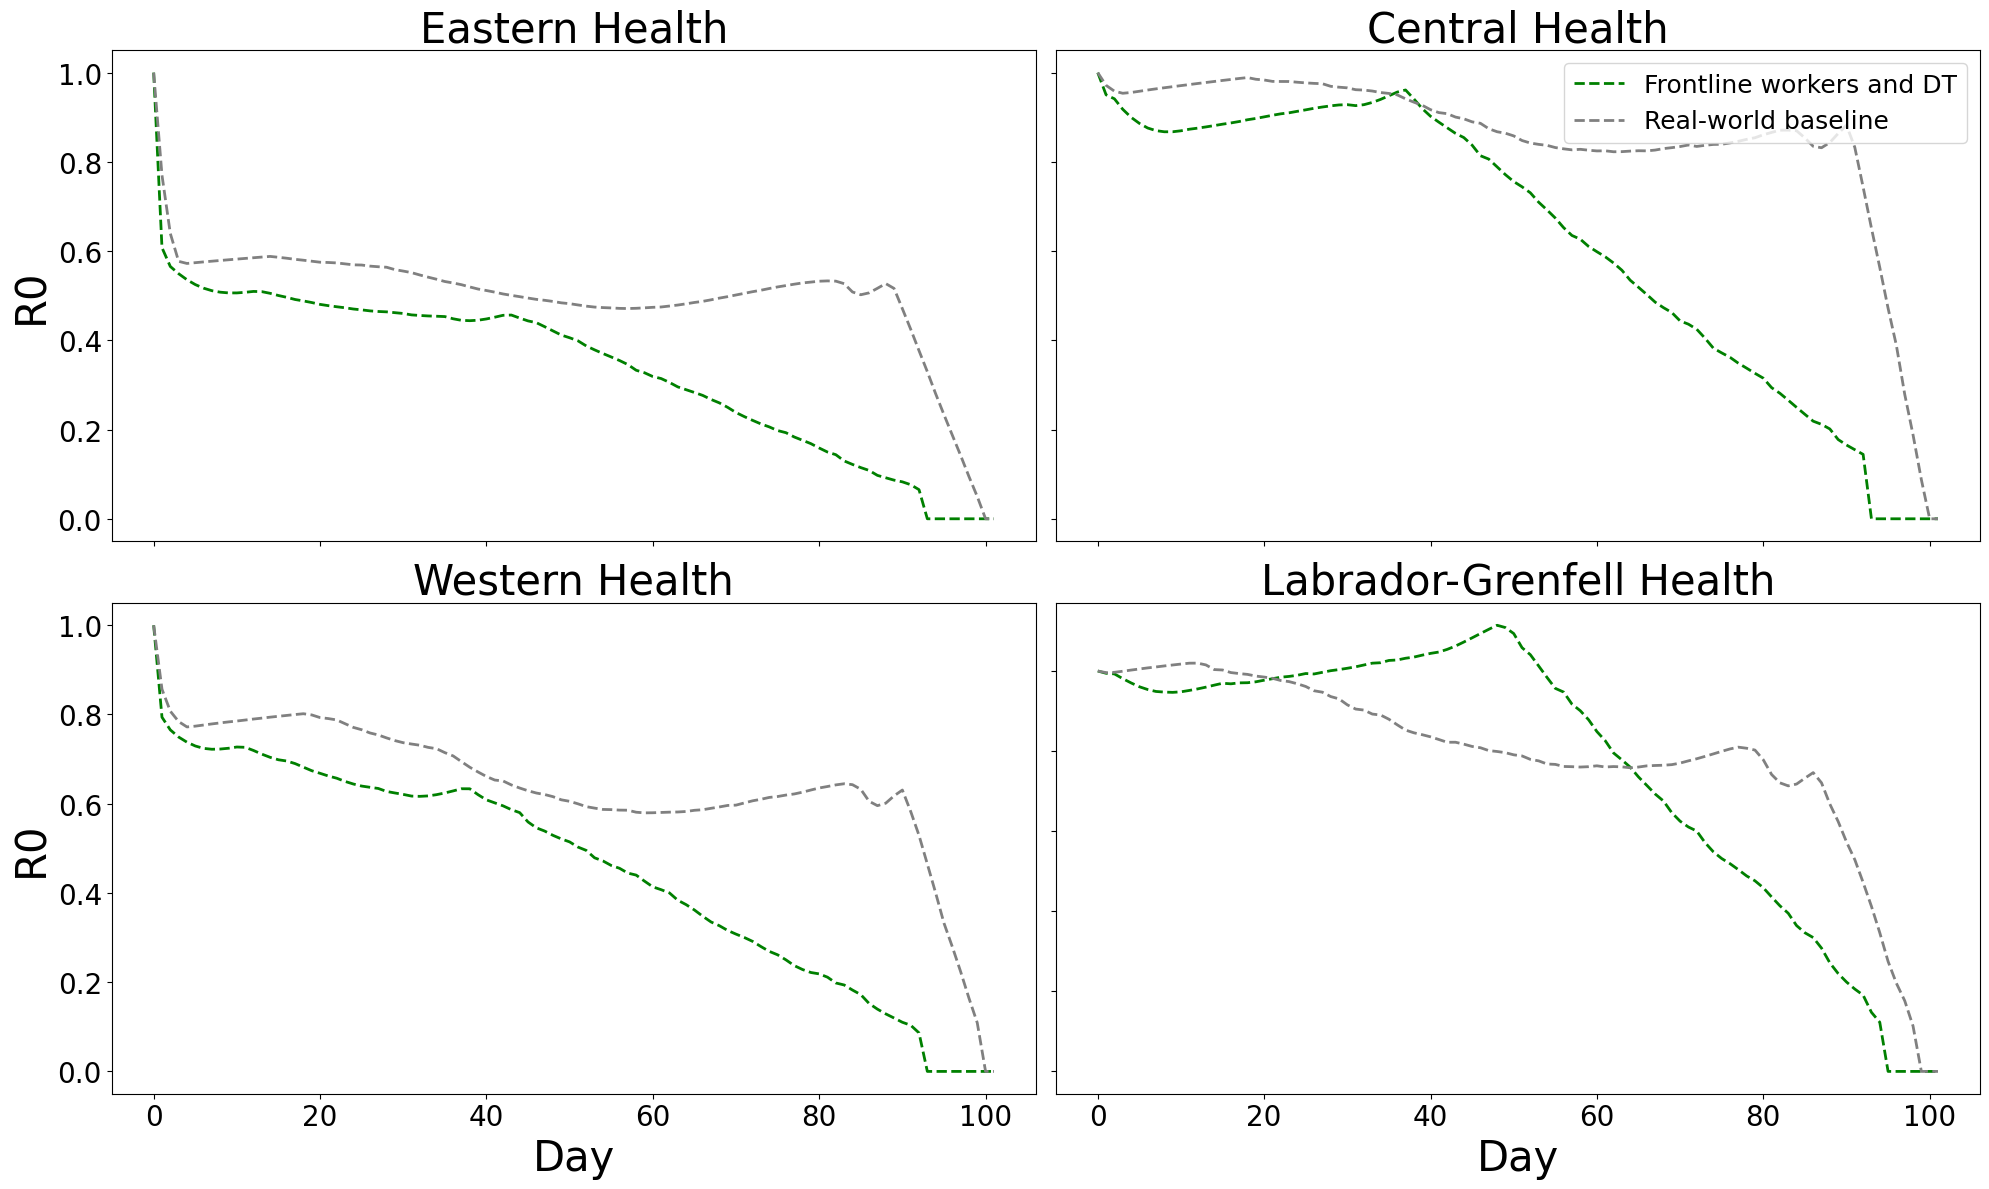

/var/folders/gs/p21_l1950qj722k64j15hmgc0000gn/T/ipykernel_12057/1526085568.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


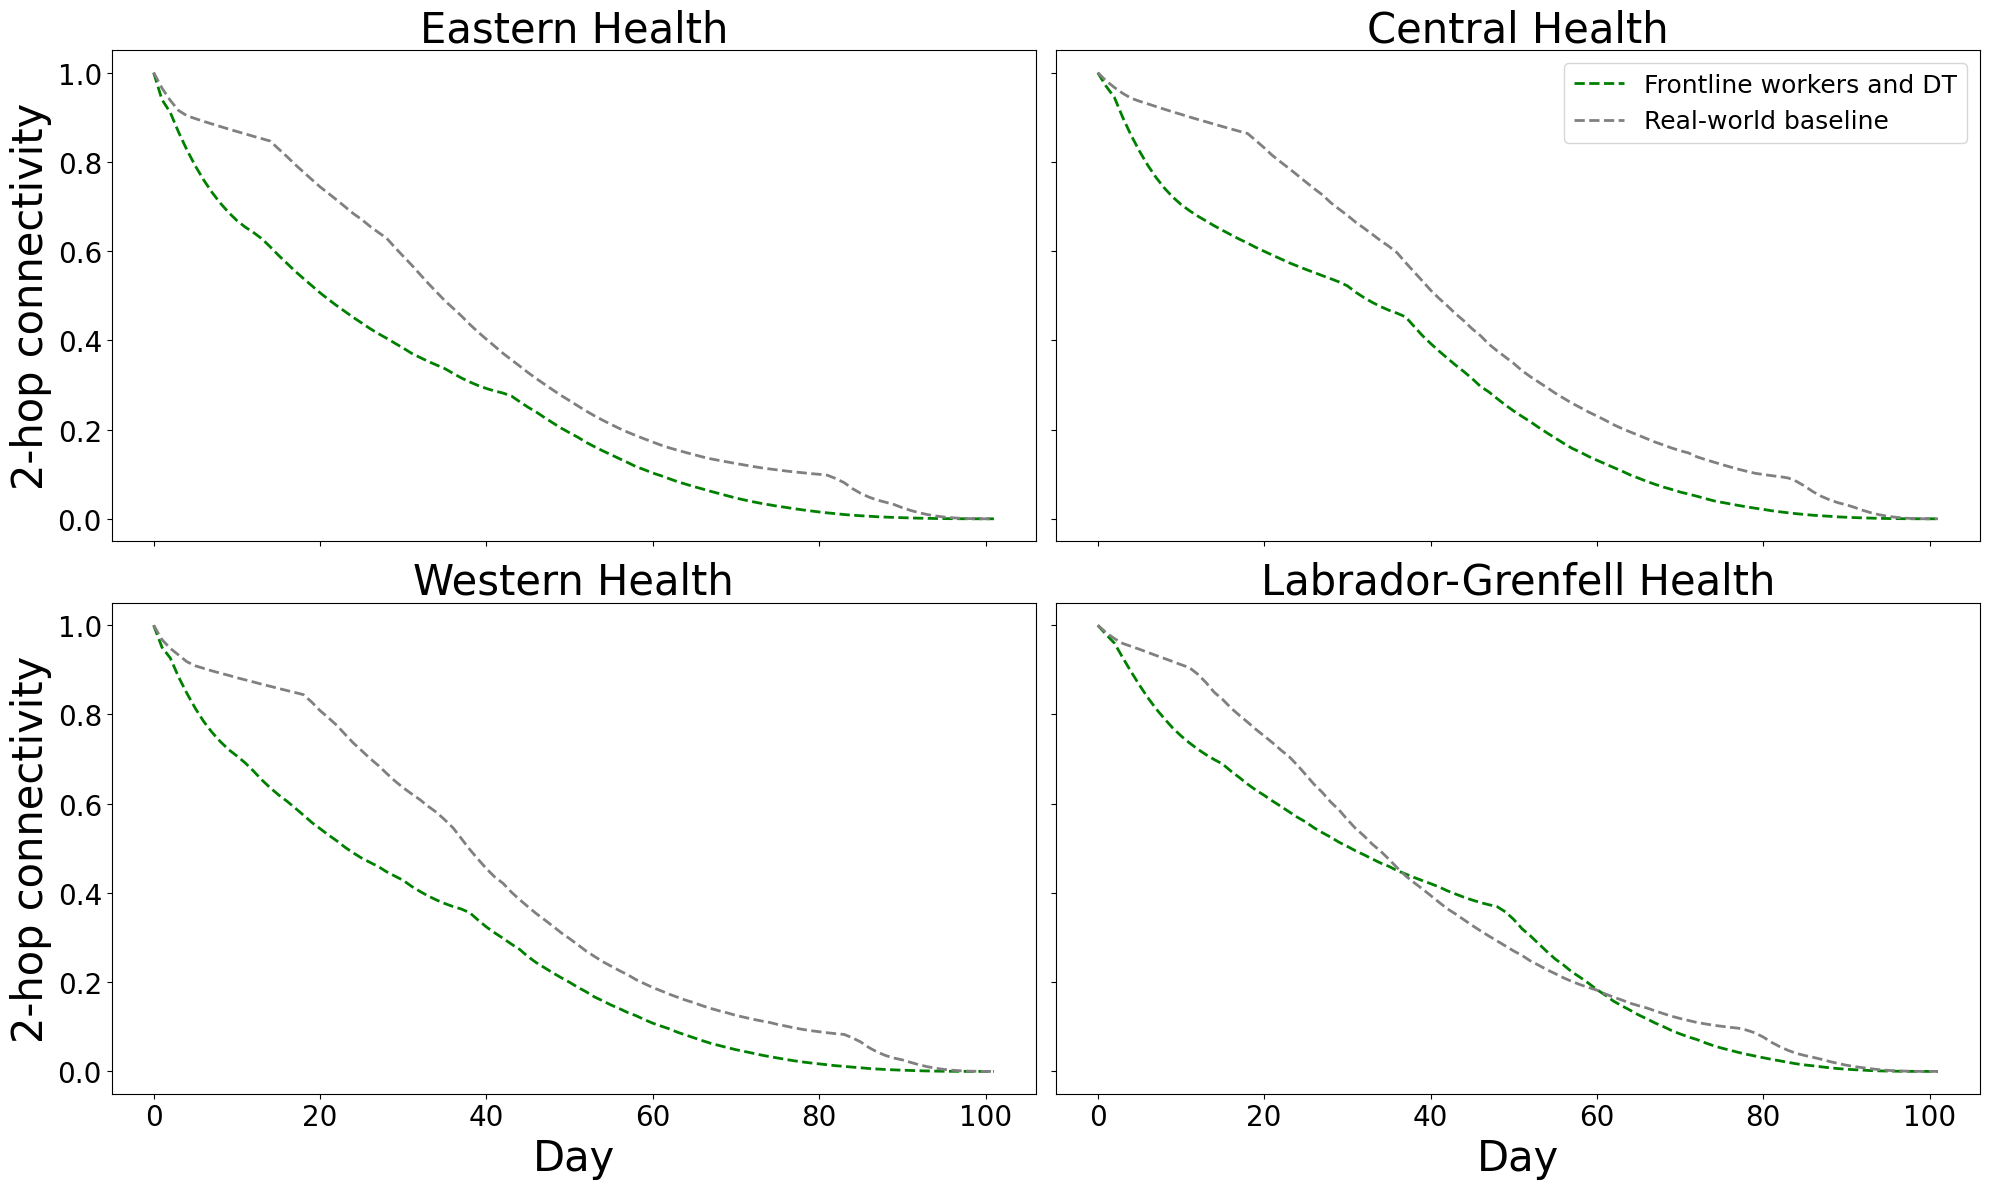

In [150]:
## Apply rollouts
HA_vaccine_fig_export_path = os.path.join(EXP_PATH, 'HA_vaccine_figures')
make_dir(HA_vaccine_fig_export_path)

#load HA_exps from json
HA_exps_import_path = os.path.join(EXP_PATH, 'HA_exps.json')
with open(HA_exps_import_path, 'r') as fp:
    HA_exps = json.load(fp)


plot_two_by_two_line_plots(HA_exps, export_path = HA_vaccine_fig_export_path, normalize=False)
plot_two_by_two_line_plots(HA_exps, export_path = HA_vaccine_fig_export_path, normalize=True)

## Decision Tree training for each Health Authority, and Overall G

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree


In [15]:
dt_fig_export_path = os.path.join('DCNDP_manu_results', 'healthAuthority_ID', '2-hop DCNDP - agg constraints','dt_figures')
make_dir(dt_fig_export_path)

In [6]:
def decision_tree_modelling(tree_df, feature_cols, labels="all", max_depth=5):

    if labels == "all":
        tree_df['label'] = tree_df['DCNDP_label'].apply(lambda x: 1 if x > 0 else 0)
    elif labels == "partitions":
        tree_df['label'] = tree_df['DCNDP_label'].apply(lambda x: 1 if x == 1 else 0)
    elif labels == "edge_cover":
        tree_df['label'] = tree_df['DCNDP_label'].apply(lambda x: 1 if x == 2 else 0)


    X_train = tree_df[feature_cols]
    Y_train = tree_df['label']

    
    clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, criterion='entropy')
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,Y_train)
    #Predict the response for test dataset
    y_pred = clf.predict(X_train)

    print("===================")
    print("Results for labels: ", labels)
    print("Max depth: ", max_depth)
    print("Criterion: ", 'entropy')
    print("Required budget: ", sum(Y_train))
    #print all metrics
    print("Accuracy:",metrics.accuracy_score(Y_train, y_pred))
    print("Precision:",metrics.precision_score(Y_train, y_pred))
    print("Recall:",metrics.recall_score(Y_train, y_pred))

    # print confusion matrix
    print(metrics.confusion_matrix(Y_train, y_pred))

    return clf, X_train, Y_train

### Load data

In [7]:
df = pd.read_csv("DCNDP_processed_data/healthAuthority_ID/2-hop DCNDP - agg constraints/G.csv")


print(df.shape)
df = df.dropna(subset=['age'])
print("df shape after removing nan: ", df.shape)

healthAuhority_names_map = {0: 'Eastern Health', 1: 'Central Health', 2: 'Western Health', 3: 'Labrador-Grenfell Health'}
def map_healthAuthoritys(value):
    return healthAuhority_names_map.get(value, 'Unknown')

df['healthAuthotity_name'] = df['healthAuthority_ID'].apply(map_healthAuthoritys)

df['healthAuthotity_name'].value_counts()

data_df = df

(508265, 26)
df shape after removing nan:  (507554, 26)


### Decision tree modelling for overall G

In [8]:

# Only looking at DCNDP solutions and skipping Min Edge Cover solutions
data_df['label'] = data_df['DCNDP_label'].apply(lambda x: 1 if x == 1 else 0)
print("Number of positive labels: ", sum(data_df['label']))

feature_set = continuous_features + categorical_features 
col_set = feature_set + ['DCNDP_label'] + ['id']
data_df = data_df[col_set]

print(data_df.shape)
data_df.head()

## Preprocessing data
for f in continuous_features:
    data_df[f] = data_df[f].astype(float)

for f in categorical_features:
    data_df[f] = data_df[f].astype('category')

data_df.head()


Number of positive labels:  100228
(507554, 11)


,age,schoolLevel,commuter,primcareWorker,hospitalWorker,isPrimCarePatient,household_number_members,household_type,workType,DCNDP_label,id
1,83.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0,1
2,61.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1,2
3,75.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0,3
4,48.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0,4
5,69.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0,5


In [9]:
# get dummy variables
df_encoded = pd.get_dummies(data_df, columns=categorical_features, prefix=categorical_features, prefix_sep='|')

df_encoded_feature_set = list(df_encoded.columns)
df_encoded_feature_set.remove('DCNDP_label')
df_encoded_feature_set.remove('id')

In [10]:
#clf, X_train, Y_train = decision_tree_modelling(data_df, feature_set, labels='partitions', max_depth=5)

clf, X_train, Y_train = decision_tree_modelling(df_encoded, df_encoded_feature_set, labels='partitions', max_depth=5)



Results for labels:  partitions
Max depth:  5
Criterion:  entropy
Required budget:  100228
Accuracy: 0.8162579745209376
Precision: 0.5550030780887437
Recall: 0.35080017559963284
[[379135  28191]
 [ 65068  35160]]


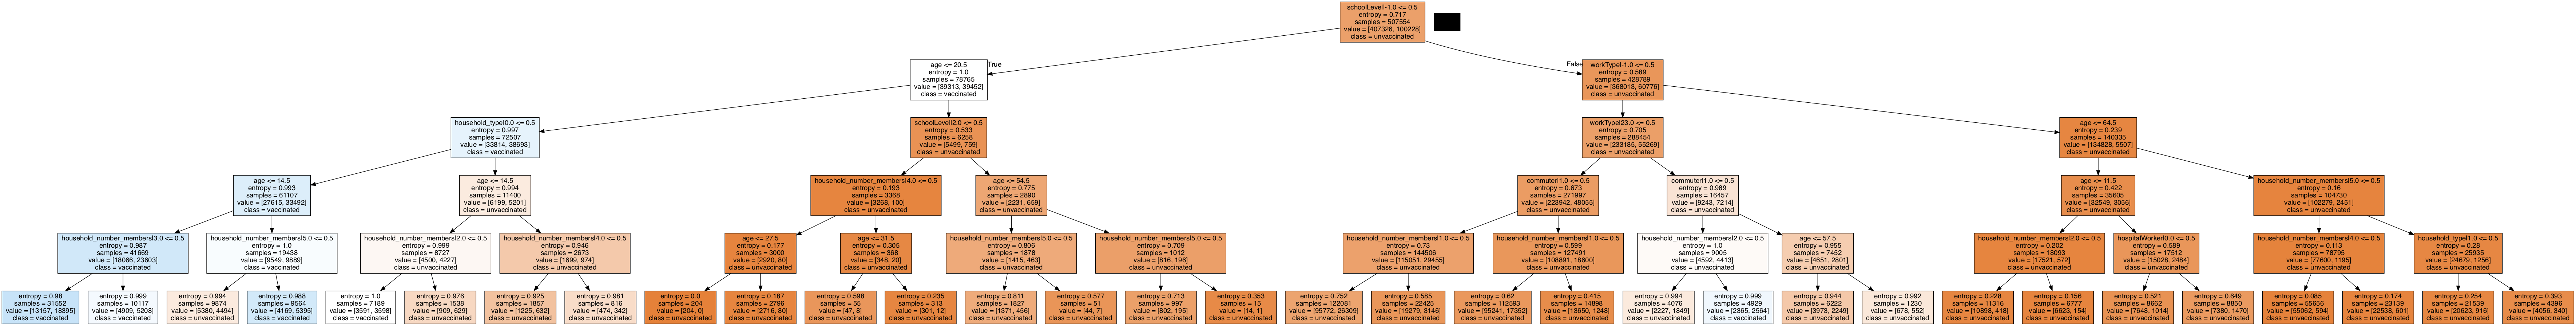

In [17]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=df_encoded_feature_set,  
                                class_names=['unvaccinated', 'vaccinated'],
                                filled=True, max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data)  
# Save graph as png
graph.write_png(os.path.join(dt_fig_export_path, 'overall_G.png'))

# Save graph as pdf
graph.write_pdf(os.path.join(dt_fig_export_path, 'overall_G.pdf'))

# Show graph
Image(graph.create_png())


### Decision tree modelling for individual regional health authorities

In [19]:
df = pd.read_csv("DCNDP_manu_results/healthAuthority_ID/2-hop DCNDP - agg constraints/G.csv")
df = df.dropna(subset=['age'])

healthAuhority_names_map = {0: 'Eastern Health', 1: 'Central Health', 2: 'Western Health', 3: 'Labrador-Grenfell Health'}
def map_healthAuthoritys(value):
    return healthAuhority_names_map.get(value, 'Unknown')

df['healthAuthotity_name'] = df['healthAuthority_ID'].apply(map_healthAuthoritys)


df['healthAuthotity_name'].value_counts()

Eastern Health              306646
Central Health               90279
Western Health               75380
Labrador-Grenfell Health     35249
Name: healthAuthotity_name, dtype: int64

In [22]:
continuous_features = ['age']
categorical_features = ['schoolLevel', 'commuter', 'primcareWorker',
'hospitalWorker', 'isPrimCarePatient', 'household_number_members', 'household_type', 'workType']

for _HA in df['healthAuthority_ID'].unique():
    #get sub_df
    data_df = df[df['healthAuthority_ID'] == _HA]
    print(_HA, " # records : ", data_df.shape[0])

    # Only looking at DCNDP solutions and skipping Min Edge Cover solutions
    data_df['label'] = data_df['DCNDP_label'].apply(lambda x: 1 if x == 1 else 0)
    print("Number of positive labels: ", sum(data_df['label']))

    feature_set = continuous_features + categorical_features 
    col_set = feature_set + ['DCNDP_label'] + ['id']
    data_df = data_df[col_set]

    ## Preprocessing data
    for f in continuous_features:
        data_df[f] = data_df[f].astype(float)

    for f in categorical_features:
        data_df[f] = data_df[f].astype('category')

    # get dummy variables
    df_encoded = pd.get_dummies(data_df, columns=categorical_features, prefix=categorical_features, prefix_sep='|')

    df_encoded_feature_set = list(df_encoded.columns)
    df_encoded_feature_set.remove('DCNDP_label')
    df_encoded_feature_set.remove('id')

    clf, X_train, Y_train = decision_tree_modelling(df_encoded, df_encoded_feature_set, labels='partitions', max_depth=7)
    
    #fig = plt.figure(figsize=(50,50))
    #_ = tree.plot_tree(clf, 
    #                    feature_names=df_encoded_feature_set,
    #                class_names=['unvaccinated', 'vaccinated'],
    #                filled=True, max_depth=3, fontsize=20)
    
    # enforce showing the plot
    #

    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=df_encoded_feature_set,  
                                class_names=['unvaccinated', 'vaccinated'],
                                filled=True, max_depth=6)

    graph = pydotplus.graph_from_dot_data(dot_data)  
    # Save graph as png
    graph.write_png(os.path.join(dt_fig_export_path, f'HA_{_HA}_dt.png'))

    # Save graph as pdf
    graph.write_pdf(os.path.join(dt_fig_export_path, f'HA_{_HA}_dt.pdf'))

    # Show graph
    Image(graph.create_png())

    plt.show(block=True)



0.0  # records :  306646
Number of positive labels:  60770
Results for labels:  partitions
Max depth:  7
Criterion:  entropy
Required budget:  60770
Accuracy: 0.8194204392035115
Precision: 0.5727930066911289
Recall: 0.349350008227744
[[230042  15834]
 [ 39540  21230]]
1.0  # records :  90279
Number of positive labels:  17752
Results for labels:  partitions
Max depth:  7
Criterion:  entropy
Required budget:  17752
Accuracy: 0.8208996555123561
Precision: 0.5670478610758153
Recall: 0.37708427219468227
[[67416  5111]
 [11058  6694]]
2.0  # records :  75380
Number of positive labels:  14814
Results for labels:  partitions
Max depth:  7
Criterion:  entropy
Required budget:  14814
Accuracy: 0.8212390554523746
Precision: 0.5839919708944925
Recall: 0.3142297826380451
[[57250  3316]
 [10159  4655]]
3.0  # records :  35249
Number of positive labels:  6892
Results for labels:  partitions
Max depth:  7
Criterion:  entropy
Required budget:  6892
Accuracy: 0.8067179210757752
Precision: 0.626198083067